# Using Pearl to solve Gymnasium's Lunar Lander with DQN and PPO in discrete and continuous action spaces

Here is a [better rendering](https://nbviewer.org/github/facebookresearch/Pearl/blob/main/tutorials/lunar_lander/lunaer_lander.ipynb) of this notebook on [nbviewer](https://nbviewer.org/).

This example shows how to use both DQN and PPO to solve the `LunarLander-v2` environment from gymnasium in discrete and continuous action spaces. 

In [ ]:
from sympy.utilities.lambdify import NUMPY
%load_ext autoreload
%autoreload 2

# Pearl Installation

If you haven't installed Pearl, please make sure you install Pearl with the following cell. Otherwise, you can skip the cell below.



In [ ]:
# Pearl installation from github. This install also includes PyTorch, Gym and Matplotlib

%pip uninstall Pearl -y
%rm -rf Pearl
!git clone https://github.com/facebookresearch/Pearl.git

In [ ]:
%cd Pearl
%pip install .
%cd ..

In [1]:
!pip install swig

In [ ]:
# Gymnasium 0.29.1 does not support Numpy 2+ right now. Either downgrade numpy to version 1+ or wait for Gymnasium 1+
# https://github.com/Farama-Foundation/Gymnasium/issues/1142
#!pip install numpy==1.26.4

In [2]:
!pip install "gymnasium[box2d]"

# Import Modules

In [1]:
import torch
import numpy as np
import gymnasium
import platform
import matplotlib.pyplot as plt

from pearl.neural_networks.sequential_decision_making.q_value_networks import VanillaQValueNetwork
from pearl.utils.functional_utils.experimentation.set_seed import set_seed
from pearl.policy_learners.sequential_decision_making.double_dqn import DoubleDQN
from pearl.policy_learners.sequential_decision_making.ppo import ProximalPolicyOptimization
from pearl.replay_buffers.sequential_decision_making.fifo_off_policy_replay_buffer import FIFOOffPolicyReplayBuffer
from pearl.policy_learners.exploration_modules.common.epsilon_greedy_exploration import EGreedyExploration
from pearl.replay_buffers.sequential_decision_making.on_policy_replay_buffer import OnPolicyReplayBuffer
from pearl.utils.functional_utils.train_and_eval.online_learning import online_learning
from pearl.pearl_agent import PearlAgent
from pearl.policy_learners.sequential_decision_making.ppo_continuous import ContinuousProximalPolicyOptimization
from pearl.utils.instantiations.environments.gym_environment import GymEnvironment
from pearl.action_representation_modules.one_hot_action_representation_module import (
    OneHotActionTensorRepresentationModule,
)

from importlib.metadata import version

set_seed(0)

In [2]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Pearl Version: {version('pearl')}")

Python Version: 3.10.14
Torch Version: 2.4.0
Is Cuda Available: False
Cuda Version: None
Gymnasium Version: 0.29.1
Numpy Version: 1.26.4
Pearl Version: 0.1.0


# CarPole-v1

In [ ]:
env_str = "CartPole-v1"
env = GymEnvironment(env_str)
print(f"Gym Environment: {env_str}")
print(f"Observation Space: {env.observation_space.shape[0]}")
print(f"Number of Actions: {env.action_space.n}")
print(f"Action Space Dimensions: {env.action_space.action_dim}")
print(f"Is Action Space Continuous: {env.action_space.is_continuous}")
env.close()

## Double DQN


In [ ]:
# Create Environment
env = GymEnvironment(env_str)

# VanillaQValueNetwork class uses a simple mlp for approximating the Q values.
#  - Input dimension of the mlp = (state_dim + action_dim)
#  - Size of the intermediate layers are specified as list of `hidden_dims`.
hidden_dims = [64, 64]

# We will be using a one hot representation for representing actions. So take action_dim = num_actions.
Q_value_network = VanillaQValueNetwork(state_dim=env.observation_space.shape[0],  # dimension of the state representation
                                       action_dim=env.action_space.n,             # dimension of the action representation
                                       hidden_dims=hidden_dims,                   # dimensions of the intermediate layers
                                       output_dim=1)                              # set to 1 (Q values are scalars)

# Instead of using the 'network_type' argument, use the 'network_instance' argument.
# Pass Q_value_network as the `network_instance` to the `DoubleDQN` policy learner.
DoubleDQNagent = PearlAgent(
    policy_learner=DoubleDQN(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        batch_size=64,
        training_rounds=10,
        soft_update_tau=0.75,
        network_instance=Q_value_network,   # pass an instance of Q value network to the policy learner.
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=env.action_space.n
        ),
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(10_000),
)

# The online learning function in Pearl implements environment interaction and learning
# and returns a dictionary with episodic returns
info_DoubleDQN = online_learning(
    agent=DoubleDQNagent,
    env=env,
    number_of_episodes=200,
    print_every_x_episodes=20,   # print returns after every 10 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    seed=0
)

env.close()

In [ ]:
# info["return"] refers to the episodic returns
torch.save(info_DoubleDQN["return"], "DoubleDQN-return.pt")
plt.plot(np.arange(len(info_DoubleDQN["return"])),
         info_DoubleDQN["return"],
         label="DoubleDQN")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

## Proximal Policy Optimization (PPO)

In [ ]:
# Create Environment
env = GymEnvironment(env_str)

# Create Pearl Agent
PPOagent = PearlAgent(
    policy_learner=ProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        use_critic=True,
        action_space=env.action_space,
        actor_hidden_dims=[64, 64],
        critic_hidden_dims=[64, 64],
        batch_size=64,
        training_rounds=10,
        critic_learning_rate=1e-3,
        actor_learning_rate=1e-3,
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=env.action_space.n,
        ),
    ),
    replay_buffer=OnPolicyReplayBuffer(250_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    number_of_episodes=750,
    print_every_x_episodes=50,
    learn_after_episode=True,
    seed=0
)

env.close()

In [ ]:
# info["return"] refers to the episodic returns
torch.save(info_PPO["return"], "info_PPO-return.pt")
plt.plot(np.arange(len(info_PPO["return"])),
         info_PPO["return"],
         label="PPO")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

# LunarLander-v2

In [13]:
env_str = "LunarLander-v2"
env = GymEnvironment(env_str)
print(f"Gym Environment: {env_str}")
print(f"Observation Space: {env.observation_space.shape[0]}")
print(f"Number of Actions: {env.action_space.n}")
print(f"Action Space Dimensions: {env.action_space.action_dim}")
print(f"Is Action Space Continuous: {env.action_space.is_continuous}")
env.close()

Gym Environment: LunarLander-v2
Observation Space: 8
Number of Actions: 4
Action Space Dimensions: 1
Is Action Space Continuous: False


## Double DQN

In [ ]:
# Create Environment
env = GymEnvironment(env_str)

# VanillaQValueNetwork class uses a simple mlp for approximating the Q values.
#  - Input dimension of the mlp = (state_dim + action_dim)
#  - Size of the intermediate layers are specified as list of `hidden_dims`.
hidden_dims = [64, 64]


# We will be using a one hot representation for representing actions. So take action_dim = num_actions.
Q_value_network = VanillaQValueNetwork(state_dim=env.observation_space.shape[0],  # dimension of the state representation
                                       action_dim=env.action_space.n,             # dimension of the action representation
                                       hidden_dims=hidden_dims,                   # dimensions of the intermediate layers
                                       output_dim=1)                              # set to 1 (Q values are scalars)

# Create Pearl Agent
# Instead of using the 'network_type' argument, use the 'network_instance' argument.
# Pass Q_value_network as the `network_instance` to the `DeepQLearning` policy learner.
DoubleDQNagent = PearlAgent(
    policy_learner=DoubleDQN(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        batch_size=64,
        network_instance=Q_value_network,   # pass an instance of Q value network to the policy learner.
        exploration_module=EGreedyExploration(0.025),
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=env.action_space.n
        ),
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(1_000_000),
)

info_DoubleDQN = online_learning(
    agent=DoubleDQNagent,
    env=env,
    number_of_episodes=3000,
    print_every_x_episodes=50,   # print returns after every 50 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    record_period=50,
    seed=0
)

env.close()

In [ ]:
# info["return"] refers to the episodic returns
torch.save(info_DoubleDQN["return"], "DoubleDQN-return.pt")
plt.plot(np.arange(len(info_DoubleDQN["return"])),
         info_DoubleDQN["return"],
         label="DoubleDQN")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

## Proximal Policy Optimization (PPO) - Discrete Action Spaces

In [ ]:
# Create Environment
env = GymEnvironment(env_str)

# Create Pearl Agent
# ProximalPolicyOptimization defaults the exploration module to PropensityExploration
PPOagent = PearlAgent(
    policy_learner=ProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        use_critic=True,
        action_space=env.action_space,
        actor_hidden_dims=[64, 64],
        critic_hidden_dims=[64, 64],
        critic_learning_rate=1e-4,
        actor_learning_rate=1e-4,
        epsilon=0.2,
        batch_size=128,
        training_rounds=10,
        entropy_bonus_scaling=0.01,
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=env.action_space.n,
        ),
    ),
    replay_buffer=OnPolicyReplayBuffer(250_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    #number_of_episodes=1000,
    number_of_steps=2_000_000,
    print_every_x_episodes=100,
    #print_every_x_steps=2048,
    learn_every_k_steps=2048,
    record_period=2048,
    learn_after_episode=False,
    seed=0
)

env.close()

In [ ]:
# info["return"] refers to the episodic returns
torch.save(info_PPO["return"], "info_PPO-return.pt")
plt.plot(np.arange(len(info_PPO["return"])),
         info_PPO["return"],
         label="PPO")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

# LunarLanderContinuous-v2

In [3]:
env_str = "LunarLanderContinuous-v2"
env = GymEnvironment(env_str)
print(f"Gym Environment: {env_str}")
print(f"Observation Space: {env.observation_space.shape[0]}")
print(f"Number of Actions: {env.action_space.shape[0]}")
print(f"Action Space Dimensions: {env.action_space.action_dim}")
print(f"Is Action Space Continuous: {env.action_space.is_continuous}")
env.close()

Gym Environment: LunarLanderContinuous-v2
Observation Space: 8
Number of Actions: 2
Action Space Dimensions: 2
Is Action Space Continuous: True


In [4]:
# Create Environment
env = GymEnvironment(env_str)

# Create Pearl Agent
PPOagent = PearlAgent(
    policy_learner=ContinuousProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        use_critic=True,
        action_space=env.action_space,
        actor_hidden_dims=[64, 64],
        critic_hidden_dims=[64, 64],
        critic_learning_rate=1e-4,
        actor_learning_rate=1e-4,
        epsilon=0.2,
        batch_size=128,
        normalize_gae=False,
        training_rounds=10,
        entropy_bonus_scaling=0.005,
    ),
    replay_buffer=OnPolicyReplayBuffer(250_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    number_of_steps=3_000_000,
    print_every_x_episodes=100,
    learn_every_k_steps=2048,
    record_period=2048,
    learn_after_episode=False,
    seed=0
)

env.close()

episode 100, step 9704, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -92.91916749626398
episode 200, step 19881, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -196.1992945075035
episode 300, step 30000, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -65.70538911223412
episode 400, step 39634, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -307.97963730990887
episode 500, step 49413, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -340.12118050456047
episode 600, step 59444, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: 13.455684209242463
episode 700, step 694

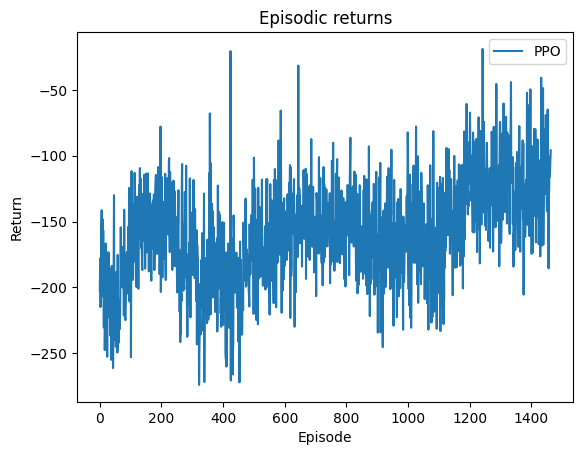

In [5]:
# info["return"] refers to the episodic returns
torch.save(info_PPO["return"], "info_PPO-return.pt")
plt.plot(np.arange(len(info_PPO["return"])),
         info_PPO["return"],
         label="PPO")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

In [6]:
# Create Environment
env = GymEnvironment(env_str)

# Create Pearl Agent
PPOagent = PearlAgent(
    policy_learner=ContinuousProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        use_critic=True,
        action_space=env.action_space,
        actor_hidden_dims=[64, 64],
        critic_hidden_dims=[64, 64],
        critic_learning_rate=1e-4,
        actor_learning_rate=1e-4,
        epsilon=0.2,
        batch_size=64,
        normalize_gae=False,
        training_rounds=10,
        entropy_bonus_scaling=0.005,
    ),
    replay_buffer=OnPolicyReplayBuffer(250_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    number_of_steps=3_000_000,
    print_every_x_episodes=100,
    learn_every_k_steps=2048,
    record_period=2048,
    learn_after_episode=False,
    seed=0
)

env.close()

episode 100, step 9428, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -721.1799403578043
episode 200, step 19245, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -780.6107312887907
episode 300, step 30425, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -204.71820890903473
episode 400, step 39994, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -657.280315965414
episode 500, step 49677, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -738.4201063513756
episode 600, step 59644, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -488.1018466548994
episode 700, step 69225

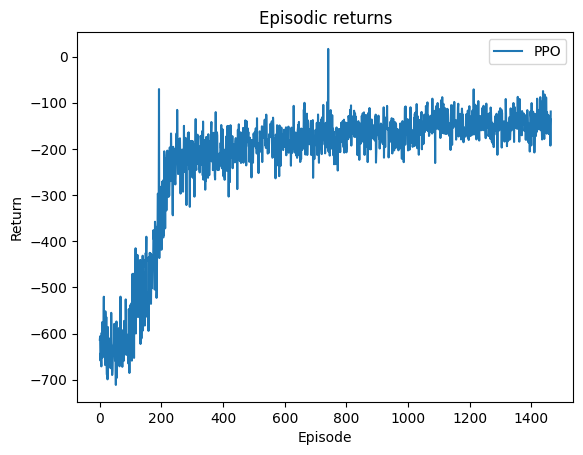

In [7]:
# info["return"] refers to the episodic returns
torch.save(info_PPO["return"], "info_PPO-return.pt")
plt.plot(np.arange(len(info_PPO["return"])),
         info_PPO["return"],
         label="PPO")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

In [8]:
# Create Environment
env = GymEnvironment(env_str)

# Create Pearl Agent
PPOagent = PearlAgent(
    policy_learner=ContinuousProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        use_critic=True,
        action_space=env.action_space,
        actor_hidden_dims=[64, 64],
        critic_hidden_dims=[64, 64],
        critic_learning_rate=3e-4,
        actor_learning_rate=3e-4,
        epsilon=0.2,
        batch_size=128,
        normalize_gae=False,
        training_rounds=10,
        entropy_bonus_scaling=0.005,
    ),
    replay_buffer=OnPolicyReplayBuffer(250_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    number_of_steps=3_000_000,
    print_every_x_episodes=100,
    learn_every_k_steps=2048,
    record_period=2048,
    learn_after_episode=False,
    seed=0
)

env.close()

episode 100, step 10506, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -400.9224479198456
episode 200, step 21376, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -406.67210748046637
episode 300, step 33363, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -123.45998405851424
episode 400, step 43601, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -279.1686827763915
episode 500, step 54782, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -126.26883925125003
episode 600, step 66148, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -154.02952587977052
episode 700, step 

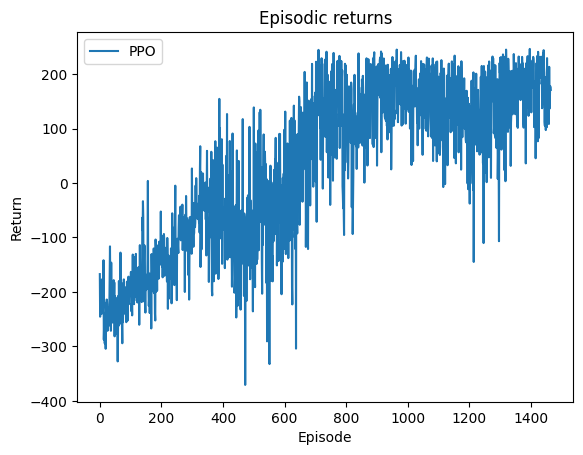

In [9]:
# info["return"] refers to the episodic returns
torch.save(info_PPO["return"], "info_PPO-return.pt")
plt.plot(np.arange(len(info_PPO["return"])),
         info_PPO["return"],
         label="PPO")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

In [10]:
# Create Environment
env = GymEnvironment(env_str)

# Create Pearl Agent
PPOagent = PearlAgent(
    policy_learner=ContinuousProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        use_critic=True,
        action_space=env.action_space,
        actor_hidden_dims=[64, 64],
        critic_hidden_dims=[64, 64],
        critic_learning_rate=3e-4,
        actor_learning_rate=3e-4,
        epsilon=0.2,
        batch_size=128,
        normalize_gae=False,
        training_rounds=20,
        entropy_bonus_scaling=0.005,
    ),
    replay_buffer=OnPolicyReplayBuffer(250_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    number_of_steps=3_000_000,
    print_every_x_episodes=100,
    learn_every_k_steps=2048,
    record_period=2048,
    learn_after_episode=False,
    seed=0
)

env.close()

episode 100, step 7276, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -101.68622049689293
episode 200, step 15495, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -80.07989517692477
episode 300, step 24324, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -101.92386469990015
episode 400, step 34279, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -355.4601807324216
episode 500, step 44564, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -191.92105802334845
episode 600, step 54965, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -392.72999698785134
episode 700, step 6

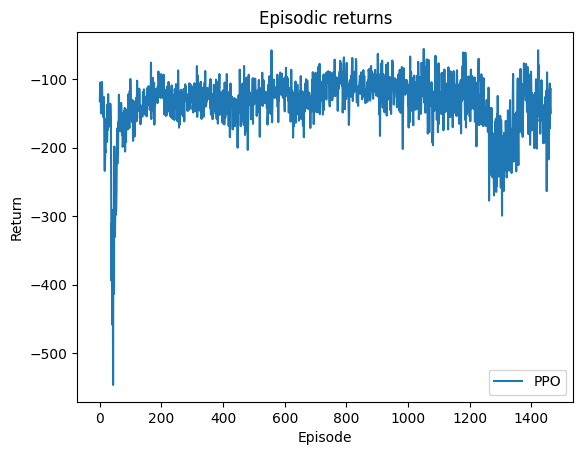

In [11]:
# info["return"] refers to the episodic returns
torch.save(info_PPO["return"], "info_PPO-return.pt")
plt.plot(np.arange(len(info_PPO["return"])),
         info_PPO["return"],
         label="PPO")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

In [12]:
# Create Environment
env = GymEnvironment(env_str)

# Create Pearl Agent
PPOagent = PearlAgent(
    policy_learner=ContinuousProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        use_critic=True,
        action_space=env.action_space,
        actor_hidden_dims=[64, 64],
        critic_hidden_dims=[64, 64],
        critic_learning_rate=3e-4,
        actor_learning_rate=3e-4,
        epsilon=0.2,
        batch_size=128,
        normalize_gae=True,
        training_rounds=20,
        entropy_bonus_scaling=0.005,
    ),
    replay_buffer=OnPolicyReplayBuffer(250_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    number_of_steps=3_000_000,
    print_every_x_episodes=100,
    learn_every_k_steps=2048,
    record_period=2048,
    learn_after_episode=False,
    seed=0
)

env.close()

episode 100, step 11520, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -434.3294123727828
episode 200, step 24186, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -355.73581521445885
episode 300, step 35890, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -207.1428229212761
episode 400, step 47995, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -435.5058632339351
episode 500, step 61997, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -347.3705702871084
episode 600, step 77329, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -131.89497303310782
episode 700, step 90

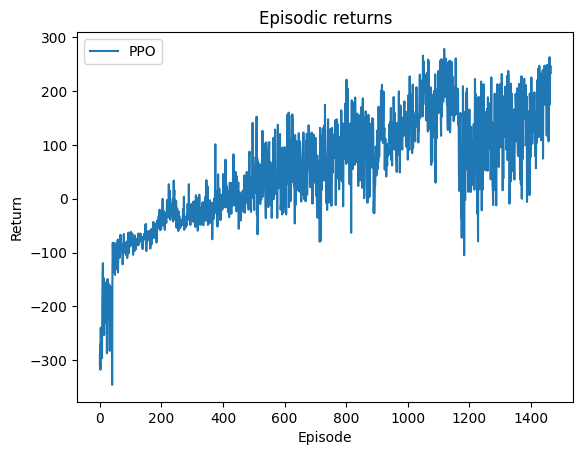

In [13]:
# info["return"] refers to the episodic returns
torch.save(info_PPO["return"], "info_PPO-return.pt")
plt.plot(np.arange(len(info_PPO["return"])),
         info_PPO["return"],
         label="PPO")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()